# Importing the Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import spacy
import random
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Bidirectional, Flatten

# Loading the Dataset

In [4]:
#loading dataset
df=pd.read_csv("LingualSense_dataset[1].csv",engine="python",encoding="UTF-8")
df.head()

,Text,Language
0,Klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


# Exploratory Data Analysis(EDA)

In [6]:
df.shape

(32336, 2)

In [7]:
df.describe().T

,count,unique,top,freq
Text,32336,32116,haec commentatio automatice praeparata res ast...,48
Language,32336,30,English,2385


In [8]:
df["Language"].value_counts()

Language
English       2385
French        2014
Spanish       1819
Russian       1692
Dutch         1546
Arabic        1536
Turkish       1474
Tamil         1469
Hindi         1062
Romanian      1000
Persian       1000
Pushto        1000
Swedish       1000
Estonian      1000
Korean        1000
Chinese       1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Japanese      1000
Thai          1000
Portugeese     739
Italian        698
Sweedish       676
Malayalam      594
German         470
Danish         428
Kannada        369
Greek          365
Name: count, dtype: int64

In [9]:
df['Text']=df['Text'].fillna('')
df.isna().sum()

Text        0
Language    0
dtype: int64

In [10]:
print("\nDuplicate Entries:")
duplicates = df[df.duplicated()]
duplicates.head(10)


Duplicate Entries:


,Text,Language
410,bisby fa roskov yr orrell tm nicolson d paglin...,Indonesian
581,haec commentatio automatice praeparata res ast...,Latin
1012,haec commentatio automatice praeparata res ast...,Latin
1027,bisby fa roskov yr orrell tm nicolson d paglin...,Indonesian
1460,haec commentatio automatice praeparata res ast...,Latin
1594,haec commentatio automatice praeparata res ast...,Latin
1792,இக்கோயில் முதன்மைத் திருக்கோயில் என்ற வகைப்பாட...,Tamil
1878,haec commentatio automatice praeparata res ast...,Latin
2134,haec commentatio automatice praeparata res ast...,Latin
2159,haec commentatio automatice praeparata res ast...,Latin


In [11]:
# removing Duplicates
df = df.drop_duplicates()

C:\Users\thota\AppData\Local\Temp\ipykernel_2316\2048806416.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Language',data=df,palette='Set1')


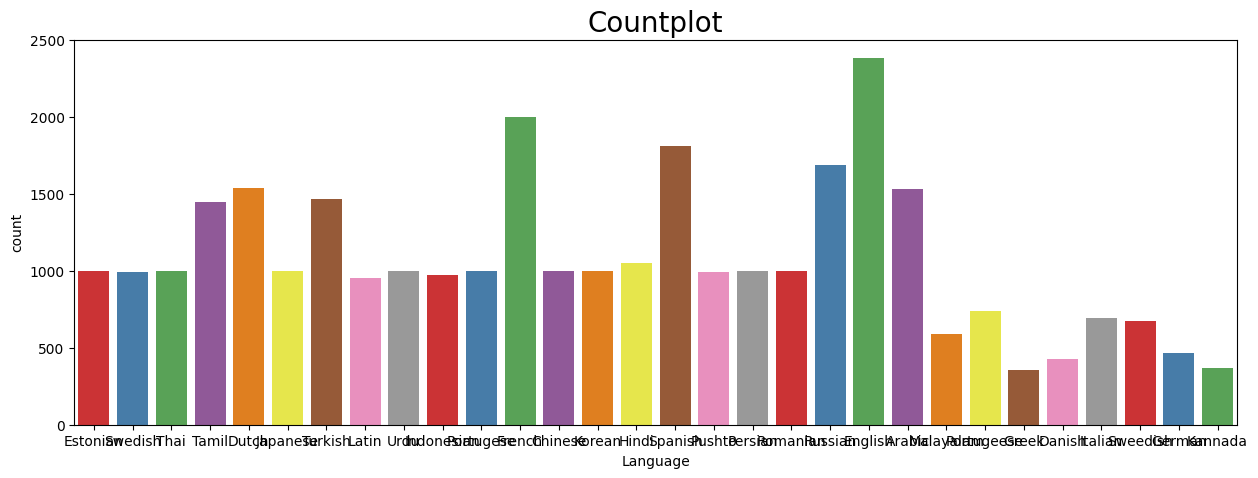

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(x='Language',data=df,palette='Set1')
plt.title('Countplot',fontsize=20)
plt.show()

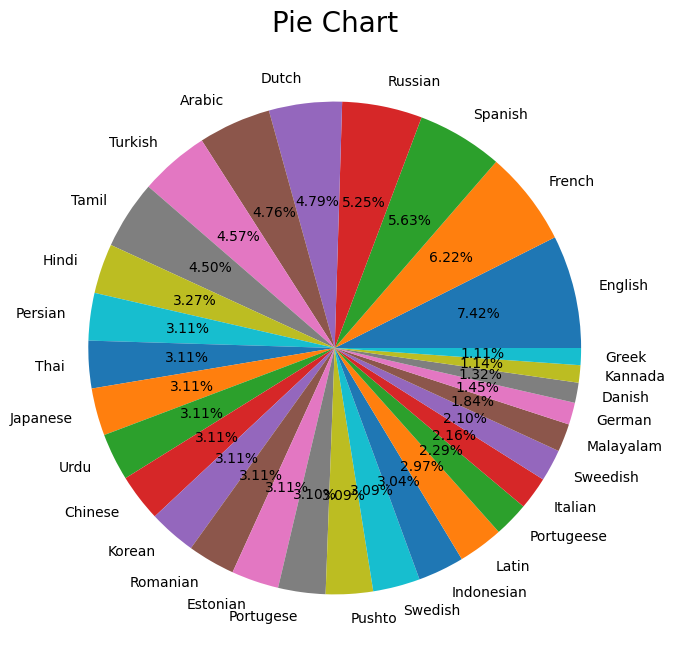

In [13]:
plt.figure(figsize=(8,8))
plt.pie(x = df['Language'].value_counts() ,autopct='%1.2f%%' ,labels=df['Language'].value_counts().index)
plt.title('Pie Chart',fontsize=20)
plt.show()

In [14]:
print(f"\nDuplicate Count:{len(duplicates)}")


Duplicate Count:212


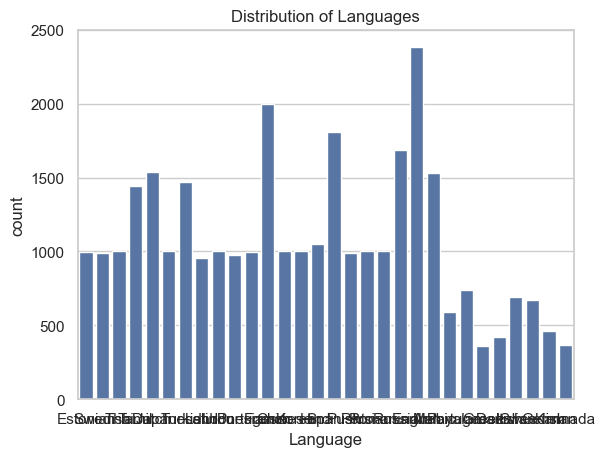

In [15]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["Language"])
plt.title("Distribution of Languages")
plt.show()

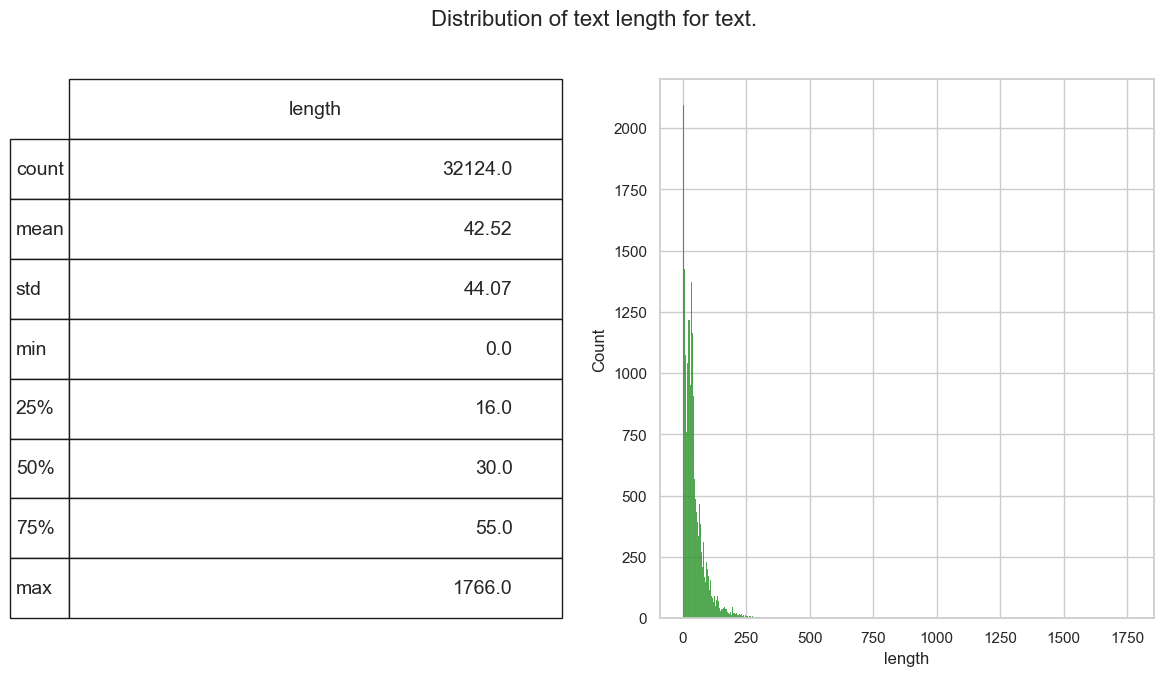

In [16]:
fig=plt.figure(figsize=(14,7))
df["length"]=df.Text.str.split().apply(len)
ax1=fig.add_subplot(122)
sns.histplot(df["length"],ax=ax1,color="green")
describe= df.length.describe().to_frame().round(2)


ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()


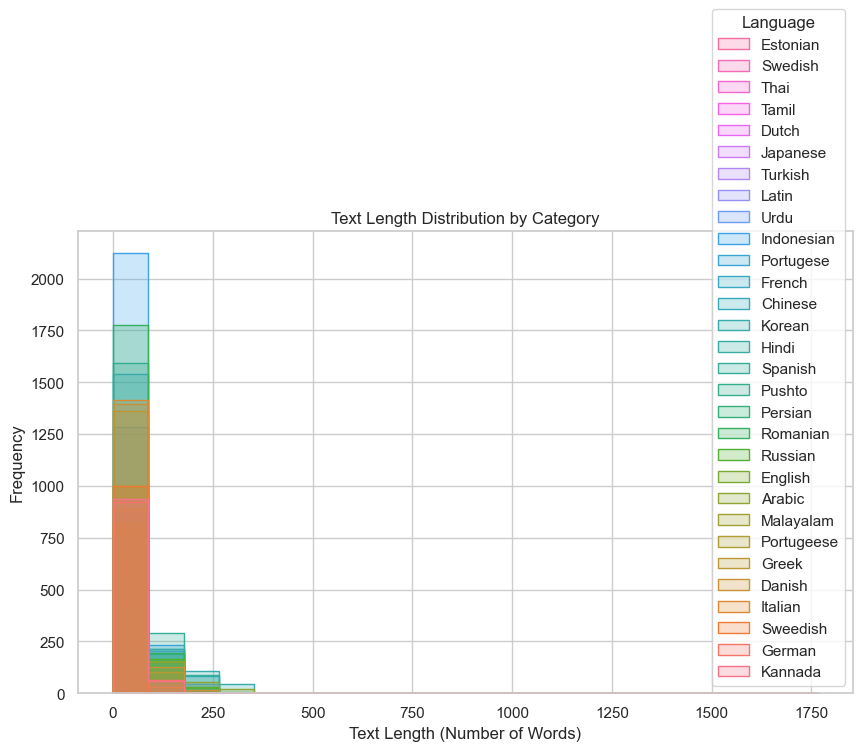

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='Language', bins=20, element='step')
plt.title("Text Length Distribution by Category")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Frequency")

unique_Language = df['Language'].unique()
plt.legend(title="Language", labels=unique_Language)

plt.show()

# Text Cleaning and Preprocessing

In [19]:
def clean_text(text):
    """
    Cleans the input text by:
    - Removing backslashes.
    - Replacing line breaks with a space.
    - Removing numeric characters.
    - Removing special characters and punctuations while preserving alphabetic characters (including Unicode letters) and spaces.
    - Reducing multiple spaces to a single space.
    - Stripping leading and trailing spaces.
    """
    # Keep only alphabetic characters (including non-English Unicode letters) and spaces
    text = re.sub(r'\\', '', text) # Remove blackslashes
    text = re.sub(r'\n', ' ', text) # Remove line breaks with a space
    text = re.sub(r'\d+', ' ', text) # Remove multiple space with a single space
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)  # Remove special characters and punctuations
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [20]:
df['Text'] = df['Text'].apply(clean_text)

In [21]:
print(df.head(10))

                                                Text  Language  length
0  Klement gottwaldi surnukeha palsameeriti ning ...  Estonian      45
1  sebes joseph pereira thomas på eng the jesuits...   Swedish      27
2  ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...      Thai      14
3  வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...     Tamil      28
4  de spons behoort tot het geslacht haliclona en...     Dutch      28
5  エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...  Japanese       1
6  tsutinalar ingilizce tsuutina kanadada alberta...   Turkish      21
7  müller mox figura centralis circulorum doctoru...     Latin      24
8  برقی بار electric charge تمام زیرجوہری ذرات کی...      Urdu     117
9  シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...  Japanese       1


In [22]:
#Convert to lowercase
df['Text'] = df['Text'].str.lower()

In [23]:
print(df.head(10))

                                                Text  Language  length
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian      45
1  sebes joseph pereira thomas på eng the jesuits...   Swedish      27
2  ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...      Thai      14
3  வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...     Tamil      28
4  de spons behoort tot het geslacht haliclona en...     Dutch      28
5  エノが行きがかりでバスに乗ってしまい気分が悪くなった際に助けるが今すぐバスを降りたいと運転手...  Japanese       1
6  tsutinalar ingilizce tsuutina kanadada alberta...   Turkish      21
7  müller mox figura centralis circulorum doctoru...     Latin      24
8  برقی بار electric charge تمام زیرجوہری ذرات کی...      Urdu     117
9  シャーリーフィールドはサンベルナルドアベニュー沿い市民センターとrtマーティン高校に隣接して...  Japanese       1


# Deep Learning Models Implementation 

In [25]:
label_encoder = LabelEncoder()
df['Language'] = label_encoder.fit_transform(df['Language'])

In [26]:
X = df['Text']
y = df['Language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

250555


In [28]:
max_length = 120
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [29]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## LSTM Model Training, Evaluation, and Prediction

In [31]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.3))
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
hist_lstm= model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 208s 498ms/step - accuracy: 0.3270 - loss: 2.3454 - val_accuracy: 0.8758 - val_loss: 0.4696
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 205s 511ms/step - accuracy: 0.8922 - loss: 0.3903 - val_accuracy: 0.9071 - val_loss: 0.3495
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 209s 521ms/step - accuracy: 0.9518 - loss: 0.1791 - val_accuracy: 0.9135 - val_loss: 0.3387
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 213s 530ms/step - accuracy: 0.9882 - loss: 0.0578 - val_accuracy: 0.9186 - val_loss: 0.4224
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 208s 517ms/step - accuracy: 0.9955 - loss: 0.0244 - val_accuracy: 0.9164 - val_loss: 0.3803
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 265s 523ms/step - accuracy: 0.9966 - loss: 0.0171 - val_accuracy: 0.9198 - val_loss: 0.4014
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 233s 579ms/step - accuracy: 0.9990 - loss: 0.0071 - val_accuracy: 0.9223 - val_loss: 0.3775
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 268s 592ms/step - accuracy: 0.9985 -

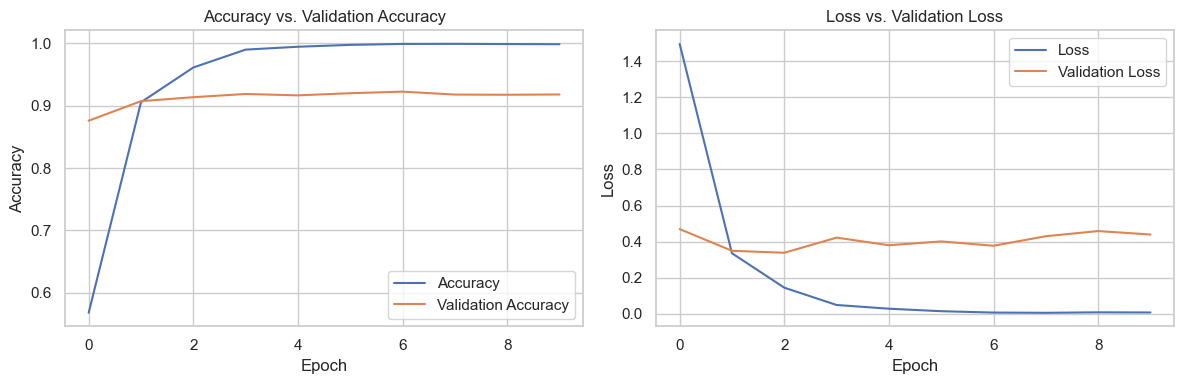

In [51]:
accuracy = hist_lstm.history['accuracy']
val_accuracy = hist_lstm.history['val_accuracy']
loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [53]:
hist_=pd.DataFrame(hist_lstm.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.568193,1.494952,0.875798,0.469591
1,0.905327,0.335851,0.907082,0.349525
2,0.961010,0.145428,0.913463,0.338728
3,0.989649,0.049585,0.918599,0.422365
4,0.994241,0.029008,0.916420,0.380267
5,0.997237,0.015159,0.919844,0.401367
6,0.998755,0.007598,0.922335,0.377455
7,0.998872,0.006313,0.917665,0.430193
8,0.998560,0.008940,0.917354,0.458793
9,0.998288,0.008096,0.917821,0.439578


In [55]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9162 - loss: 0.4259
Test Loss: 0.4396
Test Accuracy: 91.78%


In [56]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_lstm.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Classification Report:
               precision    recall  f1-score   support

      Arabic       1.00      0.97      0.98       299
     Chinese       0.28      0.06      0.10       212
      Danish       0.94      0.89      0.92        75
       Dutch       0.98      0.97      0.98       327
     English       0.94      0.96      0.95       468
    Estonian       0.93      0.98      0.95       195
      French       0.97      0.97      0.97       398
      German       0.95      0.95      0.95        93
       Greek       0.98      0.93      0.95        68
       Hindi       1.00      0.99      1.00       200
  Indonesian       0.99      0.98      0.98       216
     Italian       0.92      0.92      0.92       106
    Japanese       0.41      0.91      0.57       215
     Kannada       0.99      0.89      0.93        80
      Korean       0.99      0.97      0.98       187
       Latin       0.99      0.96      0.97       179
   Malayalam  

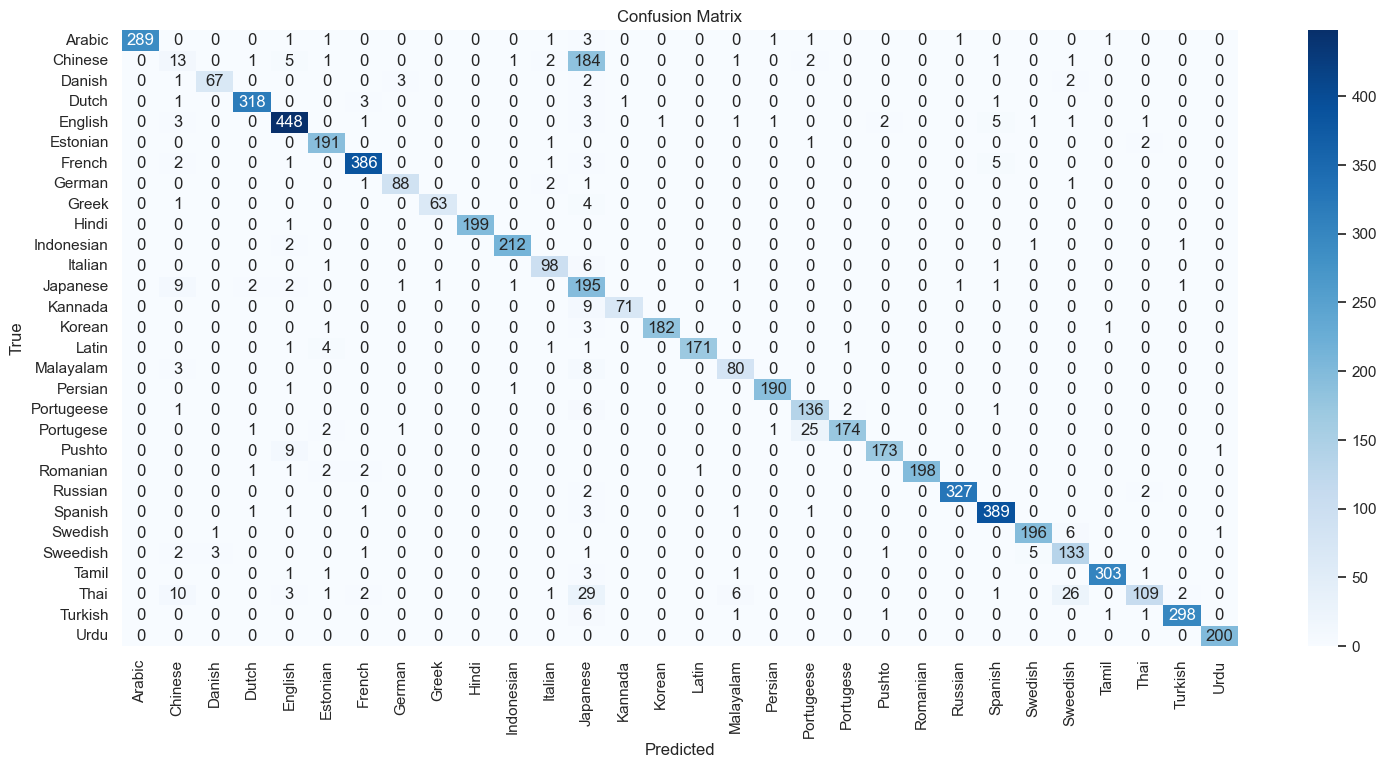

In [57]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [73]:
def predict_languages(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_language = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_language, probabilities.max()))

    return predictions

texts = [
    "Experienced patient is far better than a new doctor ",
    "Un gran poder proviene de una gran responsabilidad.",
    " Continuez à vous entraîner tous les jours Noubliez pas : Rome ne se construit pas en un jour",
    'الوقت نسبي. يمكن أن تتمدد، ويمكن أن تضغط ولكنها لا ترجع إلى الوراء أبدًا. فقط لا أستطيع'
]

predicted_languages = predict_languages( texts, model_lstm, tokenizer, max_length, label_encoder)

for text, (predicted_language, probability) in zip(texts, predicted_languages):
    print(f"Text: '{text}'")
    print(f"Predicted Language: {predicted_language}")
    print(f"Probability of {predicted_language}: {probability:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Text: 'Experienced patient is far better than a new doctor '
Predicted Language: English
Probability of English: 0.9999

Text: 'Un gran poder proviene de una gran responsabilidad.'
Predicted Language: Spanish
Probability of Spanish: 1.0000

Text: ' Continuez à vous entraîner tous les jours Noubliez pas : Rome ne se construit pas en un jour'
Predicted Language: French
Probability of French: 1.0000

Text: 'الوقت نسبي. يمكن أن تتمدد، ويمكن أن تضغط ولكنها لا ترجع إلى الوراء أبدًا. فقط لا أستطيع'
Predicted Language: Arabic
Probability of Arabic: 1.0000



## GRU Model Training, Evaluation, and Prediction

In [61]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.3))
model_gru.add(Flatten())
model_gru.add(Dense(128, activation='relu'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
hist_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 230s 551ms/step - accuracy: 0.2980 - loss: 2.4218 - val_accuracy: 0.8816 - val_loss: 0.4790
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 208s 518ms/step - accuracy: 0.8712 - loss: 0.4138 - val_accuracy: 0.9118 - val_loss: 0.4311
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 210s 522ms/step - accuracy: 0.9671 - loss: 0.1222 - val_accuracy: 0.9163 - val_loss: 0.4460
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 201s 499ms/step - accuracy: 0.9899 - loss: 0.0439 - val_accuracy: 0.9141 - val_loss: 0.4957
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 210s 523ms/step - accuracy: 0.9941 - loss: 0.0229 - val_accuracy: 0.9153 - val_loss: 0.5138
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 248s 487ms/step - accuracy: 0.9970 - loss: 0.0132 - val_accuracy: 0.9146 - val_loss: 0.4905
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 191s 475ms/step - accuracy: 0.9981 - loss: 0.0098 - val_accuracy: 0.9153 - val_loss: 0.4668
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 193s 480ms/step - accuracy: 0.9962 -

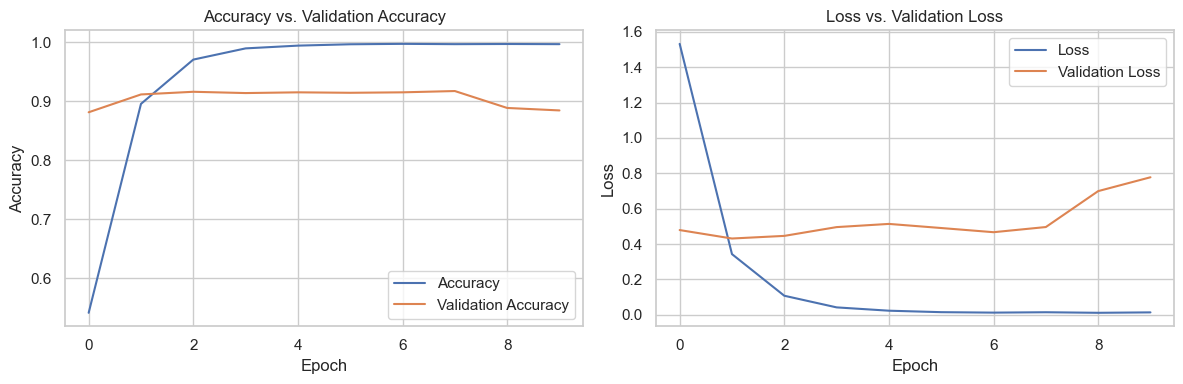

In [63]:
accuracy = hist_gru.history['accuracy']
val_accuracy = hist_gru.history['val_accuracy']
loss = hist_gru.history['loss']
val_loss = hist_gru.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [65]:
hist_=pd.DataFrame(hist_gru.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.541889,1.532585,0.881556,0.478985
1,0.895755,0.342851,0.911751,0.431147
2,0.970777,0.107348,0.916265,0.445995
3,0.989766,0.041469,0.914086,0.495706
4,0.994436,0.022705,0.915331,0.513771
5,0.996731,0.014366,0.914553,0.490501
6,0.997432,0.011807,0.915331,0.466841
7,0.996926,0.013958,0.917510,0.496054
8,0.997198,0.010788,0.888872,0.699324
9,0.996926,0.013192,0.884669,0.777721


In [66]:
loss, accuracy = model_gru.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8859 - loss: 0.7661
Test Loss: 0.7777
Test Accuracy: 88.47%


In [67]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_gru.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step
Classification Report:
               precision    recall  f1-score   support

      Arabic       0.99      0.97      0.98       299
     Chinese       0.17      0.05      0.07       212
      Danish       0.95      0.84      0.89        75
       Dutch       0.99      0.97      0.98       327
     English       0.91      0.94      0.93       468
    Estonian       0.98      0.95      0.97       195
      French       0.98      0.95      0.96       398
      German       0.97      0.96      0.96        93
       Greek       1.00      0.91      0.95        68
       Hindi       1.00      0.99      1.00       200
  Indonesian       1.00      0.98      0.99       216
     Italian       0.98      0.85      0.91       106
    Japanese       0.24      0.06      0.09       215
     Kannada       0.97      0.89      0.93        80
      Korean       0.99      0.97      0.98       187
       Latin       0.99      0.96      0.97       179
   Malayalam  

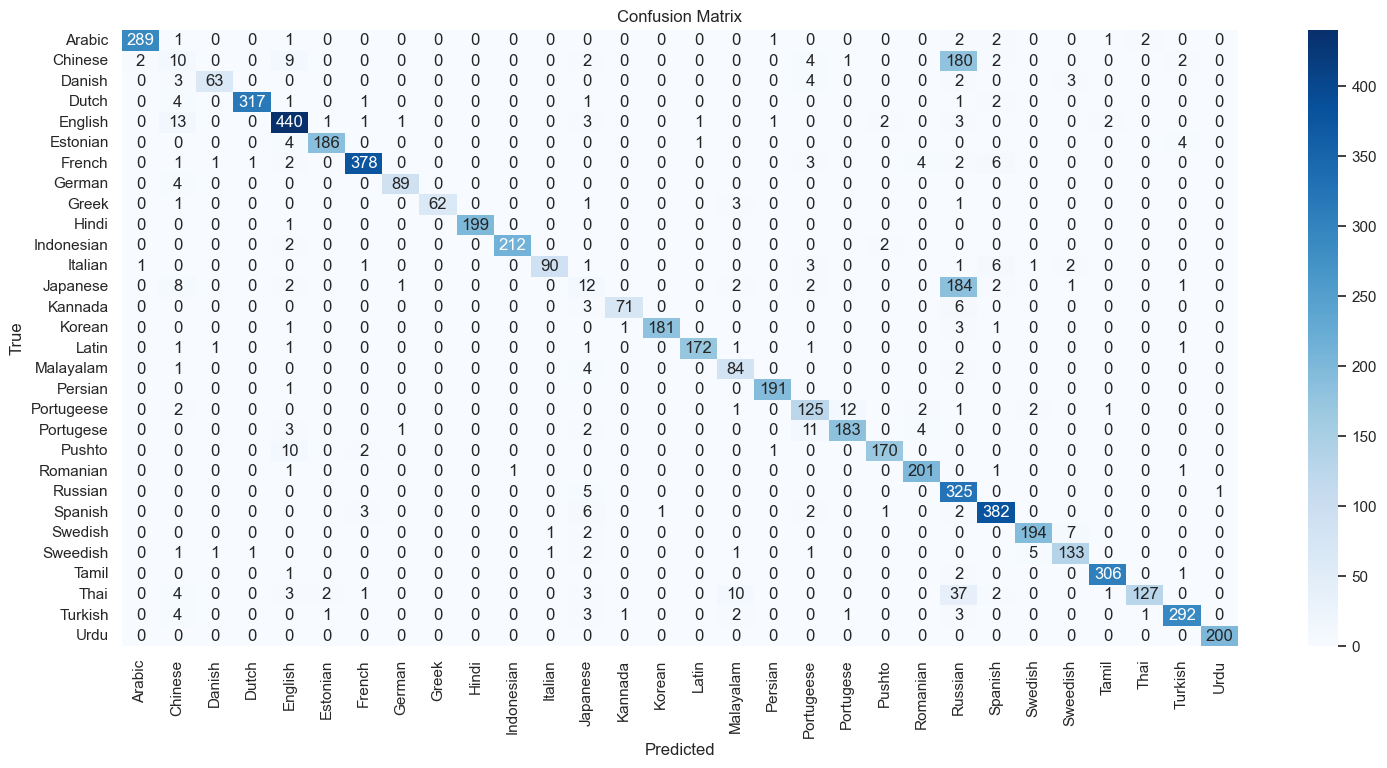

In [68]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [69]:
def predict_languages(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_language = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_language, probabilities.max()))

    return predictions

texts = [
    "Hello how are you?",
    "Hola, ¿cómo estás?",
    "Bonjour, comment ça va?",
    'مرحبا، كيف حالك؟'
]

predicted_languages = predict_languages( texts, model_gru, tokenizer, max_length, label_encoder)

for text, (predicted_language, probability) in zip(texts, predicted_languages):
    print(f"Text: '{text}'")
    print(f"Predicted Language: {predicted_language}")
    print(f"Probability of {predicted_language}: {probability:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Text: 'Hello how are you?'
Predicted Language: English
Probability of English: 0.9998

Text: 'Hola, ¿cómo estás?'
Predicted Language: Spanish
Probability of Spanish: 0.9998

Text: 'Bonjour, comment ça va?'
Predicted Language: French
Probability of French: 0.9811

Text: 'مرحبا، كيف حالك؟'
Predicted Language: Arabic
Probability of Arabic: 0.9974

